## Переобучение нейронных сетей и борьба с ним

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/girafe_ai

In [1]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________

def args_and_kwargs(*args, **kwargs):
    return args, kwargs

def parse_pytorch_model(model_str):
    def parse_layer(layer_str):
        layer_name, params = layer_str.split("(", 1)
        layer_info = {"type": layer_name.strip()}
        params_template = layer_str.replace(layer_name, "args_and_kwargs")

        param_dict = {}
        if len(params):
            args, kwargs = eval(params_template)
            if len(args) or len(kwargs):
                param_dict["args"] = args
                for name, value in kwargs.items():
                    param_dict[name] = value
        layer_info["parameters"] = param_dict
        return layer_info

    model_dict = {}
    lines = model_str.splitlines()
    model_name = lines[0].strip("()")
    model_dict["model_name"] = model_name
    model_dict["layers"] = []

    layer_regex = re.compile(r"\((\d+)\): (.+)")
    for line in lines[1:]:
        line = line.strip()
        match = layer_regex.match(line)
        if match:
            index, layer = match.groups()
            model_dict["layers"].append({"index": int(index), "layer": parse_layer(layer)})
    return model_dict

# __________end of block__________

In [3]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [4]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

--2025-04-28 19:39:02--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-04-28 19:39:02--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  --.-KB/s 

In [5]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

### Задача №1 (уже решённая): Создание и обучение модели (Separation)
Вы уже решали эту задачу ранее, так что сейчас просто воспроизведите своё решение. Оно понадобится вам в дальнейших шагах.
__Ваша первая задача всё та же: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__


In [6]:
CUDA_DEVICE_ID = 0  # change if needed

In [7]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.69MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.2MB/s]


Text(0.5, 1.0, 'Image label: 1')

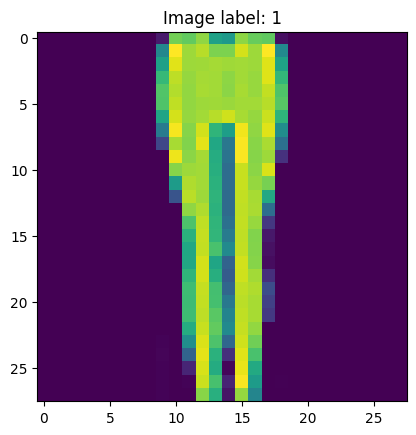

In [8]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [9]:
# Creating model instance
# your code here
class ModelTask1(nn.Module):
    def __init__(self):
        super(ModelTask1, self).__init__()
        self.linear1 = nn.Linear(28*28, 256)  # Capa más ancha
        self.linear2 = nn.Linear(256, 64)     # Reducción gradual
        self.final = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)       # Dropout intermedio
        self.batchnorm1 = nn.BatchNorm1d(256) # BatchNorm para estabilidad
        self.batchnorm2 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.batchnorm1(self.linear1(x)))
        x = self.dropout(x)
        x = self.relu(self.batchnorm2(self.linear2(x)))
        x = self.final(x)
        return x
model_task_1 = ModelTask1()

Не забудьте перенести модель на выбранный `device`!

In [10]:
model = model_task_1.to(device)

Локальные тесты для проверки вашей модели доступны ниже:

In [11]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [12]:
# your code here
# определение функции потерь и оптимизарота
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5, verbose=True)

for epoch in range(35):
    model.train()
    for inputs, labels in train_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    print(f'Epoch {epoch+1}, Test Accuracy: {acc:.4f}')

    scheduler.step(acc)  # Ajuste dinámico del LR

    if acc >= 0.885:
        print("¡Done!")
        break

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Test Accuracy: 0.8354
Epoch 2, Test Accuracy: 0.8473
Epoch 3, Test Accuracy: 0.8700
Epoch 4, Test Accuracy: 0.8678
Epoch 5, Test Accuracy: 0.8733
Epoch 6, Test Accuracy: 0.8756
Epoch 7, Test Accuracy: 0.8661
Epoch 8, Test Accuracy: 0.8778
Epoch 9, Test Accuracy: 0.8709
Epoch 10, Test Accuracy: 0.8798
Epoch 11, Test Accuracy: 0.8719
Epoch 12, Test Accuracy: 0.8805
Epoch 13, Test Accuracy: 0.8782
Epoch 14, Test Accuracy: 0.8773
Epoch 15, Test Accuracy: 0.8794
Epoch 16, Test Accuracy: 0.8804
Epoch 17, Test Accuracy: 0.8855
¡Done!


Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [13]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.92373


In [14]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.8855


Проверка, что необходимые пороги пройдены:

In [15]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Test accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`.

In [16]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
    "model_task_1": parse_pytorch_model(str(model_task_1)),
}

with open("submission_dict_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_task_1.json`")
# __________end of block__________

File saved to `submission_dict_task_1.json`


### Задача №2: Переобучение (Initiation)
Продолжим работу с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Теперь ваша задача продемонстрировать переобучение модели на обучающей выборке. Достаточно показать, что точность классификации (не только функция потерь!) на тестовой выборке значительно отстает от обучающей.

Обращаем ваше внимание, в задаче №3 вам придется починить данную модель (минимизировать эффект переобучения) с помощью механизмов регуляризации, поэтому не переусердствуйте!

__Ваша вторая задача: реализовать используя пайплан обучения модели продемонстрировать переобучения модели на обучающей выборке.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_2` для хранение модели во второй задаче.

Не используйте `Dropout` и `BatchNorm` в этой задаче

In [29]:
# Creating model instance
# your code here
class OverfitModel(nn.Module):
    def __init__(self):
        super(OverfitModel, self).__init__()
        self.linear1 = nn.Linear(28*28, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 256)
        self.linear4 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        return x

model_task_2 = OverfitModel().to(device)

In [35]:
# your code here
# Hiperparámetros para overfitting
optimizer = optim.Adam(model_task_2.parameters(), lr=0.001)  # Optimizador estándar
criterion = nn.CrossEntropyLoss()

# Entrenamiento sin validación temprana
for epoch in range(15):  # Muchas épocas
    model_task_2.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_task_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_loss += loss.item()

    # Evaluación en test (sin ajustar pesos)
    model_task_2.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_task_2(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += loss.item()

    print(f'Epoch {epoch+1}:')
    print(f'Train Loss: {train_loss/len(train_data_loader):.4f}, Train Acc: {100*correct_train/total_train:.2f}%')
    print(f'Test Loss: {test_loss/len(test_data_loader):.4f}, Test Acc: {100*correct_test/total_test:.2f}%')
    print('---')

Epoch 1:
Train Loss: 0.2309, Train Acc: 91.37%
Test Loss: 0.3704, Test Acc: 87.77%
---
Epoch 2:
Train Loss: 0.2144, Train Acc: 91.83%
Test Loss: 0.4062, Test Acc: 88.22%
---
Epoch 3:
Train Loss: 0.2088, Train Acc: 92.09%
Test Loss: 0.4112, Test Acc: 88.32%
---
Epoch 4:
Train Loss: 0.2030, Train Acc: 92.34%
Test Loss: 0.3680, Test Acc: 88.65%
---
Epoch 5:
Train Loss: 0.1970, Train Acc: 92.42%
Test Loss: 0.3737, Test Acc: 88.48%
---
Epoch 6:
Train Loss: 0.1906, Train Acc: 92.74%
Test Loss: 0.3626, Test Acc: 89.31%
---
Epoch 7:
Train Loss: 0.1907, Train Acc: 92.91%
Test Loss: 0.3602, Test Acc: 89.43%
---
Epoch 8:
Train Loss: 0.1754, Train Acc: 93.35%
Test Loss: 0.4119, Test Acc: 89.02%
---
Epoch 9:
Train Loss: 0.1797, Train Acc: 93.25%
Test Loss: 0.4039, Test Acc: 88.26%
---
Epoch 10:
Train Loss: 0.1753, Train Acc: 93.36%
Test Loss: 0.4324, Test Acc: 88.18%
---
Epoch 11:
Train Loss: 0.1653, Train Acc: 93.66%
Test Loss: 0.4040, Test Acc: 89.38%
---
Epoch 12:
Train Loss: 0.1611, Train Acc: 

Проверка архитектуры:

In [36]:
# do not change the code in the block below
# __________start of block__________
layers_task_2 = []
for element in parse_pytorch_model(str(model_task_2)).get("layers", []):
    layer_name = element["layer"]["type"]
    assert "dropout" not in layer_name.lower(), "Do not use Dropout in Task 2!"
    assert "batchnorm" not in layer_name.lower(), "Do not use BatchNorm in Task 2!"
    layers_task_2.append(layer_name)
# __________end of block__________

Оценим качество классификации:

In [37]:
train_acc_task_2 = get_accuracy(model_task_2, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_2:3.5}")

Neural network accuracy on train set: 0.94845


In [38]:
test_acc_task_2 = get_accuracy(model_task_2, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_2:3.5}")

Neural network accuracy on test set: 0.8973


Проверка, что переобучение присутствует:

In [39]:
assert train_acc_task_2 >= test_acc_task_2, "Train accuracy must be higher than task accuracy"
assert train_acc_task_2 >= 0.88, "Train accuracy must be higher than 0.88"
assert (
    train_acc_task_2 - test_acc_task_2 >= 0.04
), "Test accuracy should be at least 0.04 lower that train."

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_2`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задачи №1. Если их там нет, загрузите их из сохраненного файла в переменную перед запуском следующей ячейки.

In [40]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_2": parse_pytorch_model(str(model_task_2)),
    }
)

with open("submission_dict_tasks_1_and_2.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_tasks_1_and_2.json`")
# __________end of block__________

File saved to `submission_dict_tasks_1_and_2.json`


### Задача №3: Исправление модели (Return)
Все так же работаем с [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Наконец, ваша задача исправить ~~ошибки прошлого~~ переобучение модели, построенной в задаче 2. Достаточно добиться расхождения между точностью классификации на обучающей и тестовой выборках не превышающего 0.015 (т.е. полутора процентов).

Обращаем ваше внимание, архитектура модели в задаче №3 не должна существенно отличаться от задачи №2! Вы можете использовать Batchnorm, Dropout, уменьшить размерность промежуточных представлений, обратиться к аугментации данных, но вы не можете использовать меньшее количество слоёв.

__Ваша третья и финальная задача: исправить модель и/или процесс обучения, дабы справиться с переобучением.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_3` для хранение модели во второй задаче.

Также код ниже будет обращаться к переменной `layers_task_2`, инициализируйте её, если она не определена.

In [41]:
# do not change the code in the block below
# __________start of block__________
assert (
    layers_task_2 is not None
), "Initializa layers_task_2 vairable which contains list of layers in task 2 model"
# __________end of block__________

In [60]:
class BalancedModel(nn.Module):
    def __init__(self):
        super(BalancedModel, self).__init__()
        self.linear1 = nn.Linear(28*28, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 64)
        self.linear4 = nn.Linear(64, 10)

        # Увеличиваем дропаут
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.35)

        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(64)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dropout1(self.relu(self.bn1(self.linear1(x))))
        x = self.dropout2(self.relu(self.bn2(self.linear2(x))))
        x = self.dropout3(self.relu(self.bn3(self.linear3(x))))
        x = self.linear4(x)
        return x

# Inicialización
model_task_3 = BalancedModel().to(device)
optimizer = optim.AdamW(model_task_3.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.7, min_lr=1e-6)

In [61]:
from torchvision import transforms

augmentation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(3),  # Rotación muy ligera
    transforms.RandomAffine(
        degrees=0,
        translate=(0.03, 0.03),  # Traslación mínima
        scale=None,  # Sin escalado
        shear=None  # Sin distorsión
    ),
    transforms.ToTensor()
])

class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Creamos un nuevo dataset con data augmentation
augmented_train_dataset = AugmentedDataset(train_fmnist_data, augmentation_transform)

# Creamos un nuevo dataloader con el dataset aumentado
augmented_train_loader = torch.utils.data.DataLoader(
    augmented_train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

In [62]:
# Inicialización
model_task_3 = BalancedModel().to(device)
optimizer = optim.AdamW(model_task_3.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

best_test_acc = 0
best_gap = float('inf')

for epoch in range(20):
    model_task_3.train()
    train_loss = 0.0

    # Usamos el loader con data augmentation para entrenar
    for inputs, labels in augmented_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_task_3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validación - usamos los loaders originales para una evaluación consistente
    train_acc = get_accuracy(model_task_3, train_data_loader)  # Sin augmentation para evaluar
    test_acc = get_accuracy(model_task_3, test_data_loader)
    current_gap = train_acc - test_acc

    # Ajuste dinámico
    scheduler.step(test_acc)

    print(f'Epoch {epoch+1}:')
    print(f'Train: {train_acc:.4f} | Test: {test_acc:.4f} | Gap: {current_gap:.4f}')

    # Criterios de parada
    if train_acc > 0.88 and test_acc > 0.865 and current_gap <= 0.015:
        print("¡Condición cumplida!")
        break

Epoch 1:
Train: 0.8380 | Test: 0.8264 | Gap: 0.0116
Epoch 2:
Train: 0.8594 | Test: 0.8502 | Gap: 0.0092
Epoch 3:
Train: 0.8679 | Test: 0.8570 | Gap: 0.0109
Epoch 4:
Train: 0.8741 | Test: 0.8621 | Gap: 0.0120
Epoch 5:
Train: 0.8777 | Test: 0.8684 | Gap: 0.0093
Epoch 6:
Train: 0.8838 | Test: 0.8725 | Gap: 0.0113
¡Condición cumplida!


Проверка архитектуры:

In [63]:
# do not change the code in the block below
# __________start of block__________
layers_task_3 = []
for element in parse_pytorch_model(str(model_task_3)).get("layers", []):
    layer_name = element["layer"]["type"]
    layers_task_3.append(layer_name)


idx = 0
for model_3_layer in layers_task_3:
    model_2_layer = layers_task_2[idx]
    if "dropout" not in model_3_layer.lower() and "batchnorm" not in model_3_layer.lower():
        assert (
            model_3_layer == model_2_layer
        ), "Models in tasks 2 and 3 must share the architecture except for Dropout and BatchNorm!"
        idx += 1
# __________end of block__________

Оценим качество классификации:

In [64]:
train_acc_task_3 = get_accuracy(model_task_3, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_3:3.5}")

Neural network accuracy on train set: 0.8838


In [65]:
test_acc_task_3 = get_accuracy(model_task_3, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_3:3.5}")

Neural network accuracy on test set: 0.8725


Проверка, что переобучение присутствует:

In [66]:
assert train_acc_task_3 >= 0.88, "Train accuracy must be higher than 0.88"
assert train_acc_task_3 >= 0.865, "Test accuracy must be higher than 0.865"
assert (
    train_acc_task_3 - test_acc_task_3 <= 0.015
), "Test accuracy should not be lower that train more than by 0.015"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_3`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задач №1 и №2. Если их там нет, загрузите их из сохраненных файлов перед запуском следующей ячейки.

In [67]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_3": parse_pytorch_model(str(model_task_3)),
    }
)

with open("submission_dict_final.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_final.json`")
# __________end of block__________

File saved to `submission_dict_final.json`


### Сдача задания
Сдайте сгенерированные файлы в соответствующие задачи в соревновании, а именно:
* `submission_dict_tasks_1_and_2.json` в задачу Initiation
* `submission_dict_final.json` в задачу Return.


`submission_dict_task_1.json` сдавать не нужно, он уже был сдан ранее.

На этом задание завершено. Поздравляем!